In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import glob
import h5py
import netCDF4 as nc
from scipy import stats
from pytz import all_timezones


In [2]:
def MJDtoDT(mjd2k):
    """Take the modified julian day from 2000, convert to seconds, add to seconds since jan 1,00:00:00.00"""
    t0 = dt.datetime.utcfromtimestamp(0.0)
    t2k = dt.datetime(2000,1,1,0,0,0)
    t2k = (t2k-t0).total_seconds()
    tmjd = mjd2k * 86400
    date = dt.datetime.utcfromtimestamp(t2k+tmjd)
    return date

In [3]:
ds = nc.Dataset('test.hdf')

In [4]:
mjd2k = ds["DATETIME"][()]
o3column = ds["O3.COLUMN_ABSORPTION.SOLAR"][()]

<ipython-input-4-c2e7fa86893f>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mjd2k = ds["DATETIME"][()]
<ipython-input-4-c2e7fa86893f>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  o3column = ds["O3.COLUMN_ABSORPTION.SOLAR"][()]


In [5]:
time = np.array([MJDtoDT(ele) for ele in mjd2k])
print(time)

[datetime.datetime(2012, 10, 26, 20, 48, 33, 120000)
 datetime.datetime(2012, 10, 26, 21, 2, 13, 920000)
 datetime.datetime(2012, 10, 26, 21, 16, 56, 64000) ...
 datetime.datetime(2021, 7, 24, 18, 16, 50, 880000)
 datetime.datetime(2021, 7, 24, 19, 50, 19, 968000)
 datetime.datetime(2021, 7, 24, 19, 57, 46, 656000)]


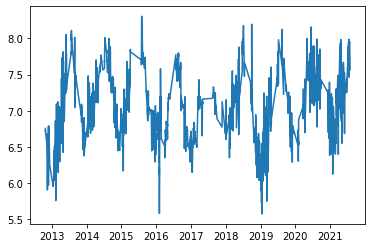

In [6]:
plt.plot(time,o3column)

In [7]:
tempdict = {'time': time, 'o3column': o3column}
smalldf = pd.DataFrame(data=tempdict)
smalldf

,time,o3column
0,2012-10-26 20:48:33.120,6.756701
1,2012-10-26 21:02:13.920,6.717759
2,2012-10-26 21:16:56.064,6.727473
3,2012-11-16 13:29:04.704,6.483526
4,2012-11-16 13:36:58.176,6.505157
...,...,...
4635,2021-07-24 16:28:47.424,7.946076
4636,2021-07-24 16:36:13.248,7.922451
4637,2021-07-24 18:16:50.880,7.949151
4638,2021-07-24 19:50:19.968,7.943056


In [8]:
#localization of dataframe so that datetime is UTC and not naive
timeutc=smalldf.time.dt.tz_localize('Etc/UTC')
timelocal=timeutc.dt.tz_convert('Etc/GMT+6')
smalldflocal = smalldf.assign(time=timelocal)
#make timeseries
smallts = smalldflocal.set_index('time')
#make mean and stdevs
smalltsmean_hr = smallts.o3column.groupby(smallts.index.hour).mean()
smalltsstd_hr = smallts.o3column.groupby(smallts.index.hour).std()
smalltsmean_mnt = smallts.o3column.groupby(smallts.index.month).mean()
smalltsstd_mnt = smallts.o3column.groupby(smallts.index.month).std()
smalltsmean_yr = smallts.o3column.groupby(smallts.index.year).mean()
smalltsstd_yr = smallts.o3column.groupby(smallts.index.year).std()

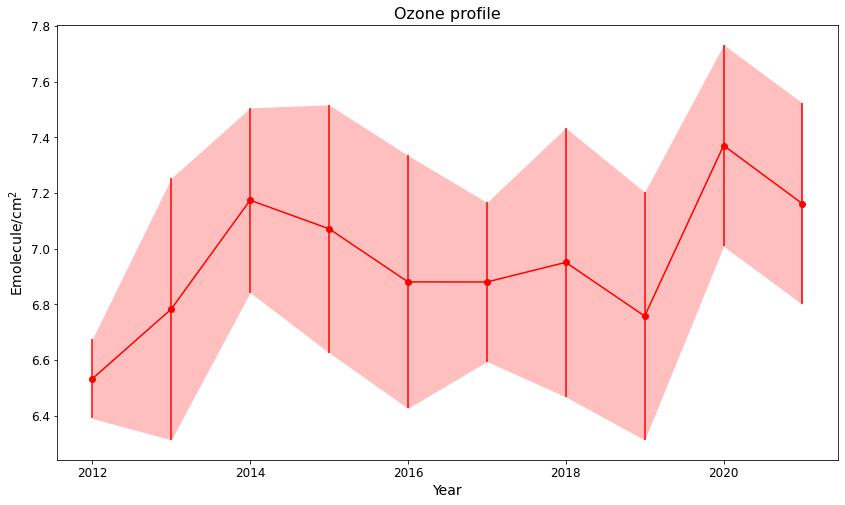

In [9]:
## pyplot plotting SINGLE
# PANDONIA = loc, MERRA2 = merra, FTIR = ftir
# varname format = ts + source + mean/std + hourly(none)/monthly(mt) + total(none)/trop/strat 
# e.g. tsmerrameanmttrop

# Variable definition
x1 = smalltsmean_hr.index
y1 = smalltsmean_hr
err1 = smalltsstd_hr
x2 = smalltsmean_mnt.index
y2 = smalltsmean_mnt
err2 = smalltsstd_mnt
x3 = smalltsmean_yr.index 
y3 = smalltsmean_yr
err3 = smalltsstd_yr
x4 = smallts.index 
y4 = smallts

### INITIALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))

## line and stdev
#ax1.plot(x1, y1, '-b')
#ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
#ax1.plot(x2, y2, '-g')
#ax1.fill_between(x2, y2-err2, y2+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
ax1.plot(x3, y3, '-r')
ax1.fill_between(x3, y3-err3, y3+err3,alpha=.25, edgecolor='#3F7F4C', facecolor='r',linewidth=0)

## LABEL, marker and errorbar
#ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
#ax1.errorbar(x2, y2, yerr=err2, fmt='go', label='')
ax1.errorbar(x3, y3, yerr=err3, fmt='ro', label='')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax1.set_xlabel('Year',size=14)
ax1.set_ylabel('Emolecule/cm$^2$',size=14)
ax1.set_title("Ozone profile",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

## SAVEFIG
#plt.savefig('D:\\CCA\\PANDONIA\\diurnalO3PanAltzMERRA.png')

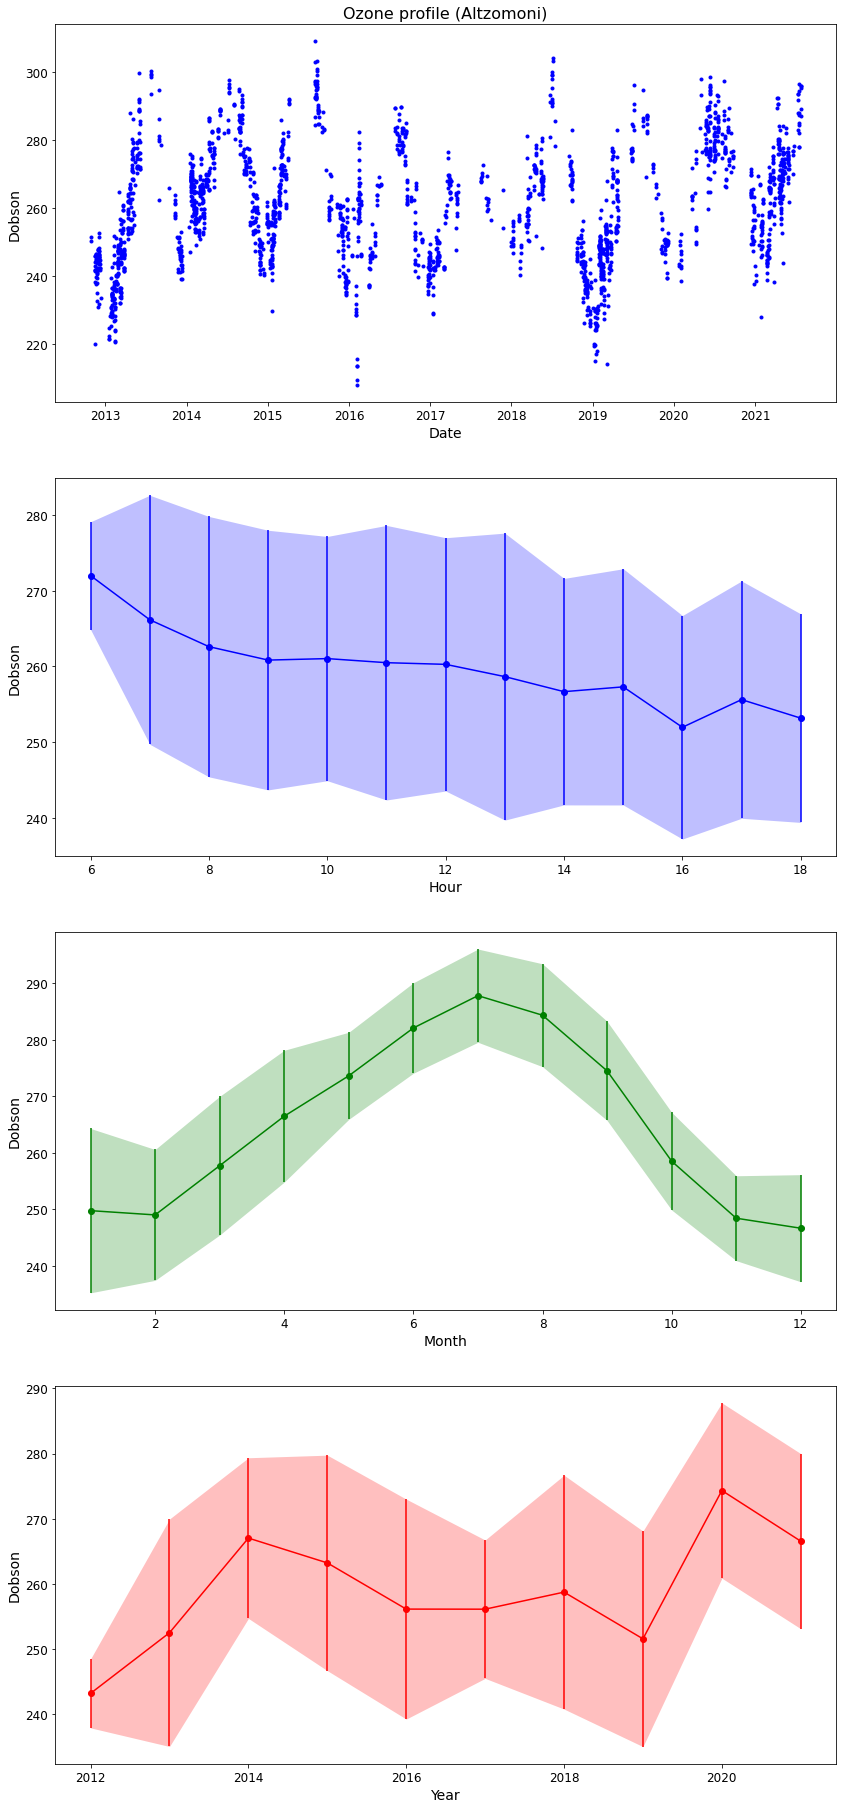

In [10]:
## pyplot plotting MULTI
# PANDONIA = loc, MERRA2 = merra, FTIR = ftir
# varname format = ts + source + mean/std + hourly(none)/monthly(mt) + total(none)/trop/strat 
# e.g. tsmerrameanmttrop

# Variable definition
x1 = smalltsmean_hr.index
y1 = smalltsmean_hr*1e18*10000/2.6867e20
err1 = smalltsstd_hr*1e18*10000/2.6867e20
x2 = smalltsmean_mnt.index
y2 = smalltsmean_mnt*1e18*10000/2.6867e20
err2 = smalltsstd_mnt*1e18*10000/2.6867e20
x3 = smalltsmean_yr.index 
y3 = smalltsmean_yr*1e18*10000/2.6867e20
err3 = smalltsstd_yr*1e18*10000/2.6867e20
x4 = smallts.resample('H').mean().index 
y4 = smallts.resample('H').mean()*1e18*10000/2.6867e20

plt.figure(figsize=(14,32)) 

ax0 = plt.subplot(4, 1, 1) 
## line and stdev
ax0.plot(x4, y4, '.b')
#ax0.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
## LABEL, marker and errorbar
#ax0.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile (Altzomoni)",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

ax1 = plt.subplot(4, 1, 2) 
## line and stdev
ax1.plot(x1, y1, '-b')
ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
## LABEL, marker and errorbar
ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax1.set_xlabel('Hour',size=14)
ax1.set_ylabel('Dobson',size=14)
#ax1.set_title("Ozone profile (Altzomoni)",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

ax2 = plt.subplot(4, 1, 3) 
## line and stdev
ax2.plot(x2, y2, '-g')
ax2.fill_between(x2, y2-err2, y2+err2,alpha=.25, edgecolor='#3F7F4C', facecolor='g',linewidth=0)
## LABEL, marker and errorbar
ax2.errorbar(x2, y2, yerr=err2, fmt='go', label='')
## Formatting 
#ax2.set_xticks(np.arange(0,24))
ax2.set_xlabel('Month',size=14)
ax2.set_ylabel('Dobson',size=14)
#ax2.set_title("Ozone profile",size=16)
#ax2.legend(fontsize=12, loc='upper left')
ax2.tick_params(labelsize=12)

ax3 = plt.subplot(4, 1, 4) 
## line and stdev
ax3.plot(x3, y3, '-r')
ax3.fill_between(x3, y3-err3, y3+err3,alpha=.25, edgecolor='#3F7F4C', facecolor='r',linewidth=0)
## LABEL, marker and errorbar
ax3.errorbar(x3, y3, yerr=err3, fmt='ro', label='')
## Formatting 
#ax3.set_xticks(np.arange(0,24))
ax3.set_xlabel('Year',size=14)
ax3.set_ylabel('Dobson',size=14)
#ax3.set_title("Ozone profile",size=16)
#ax3.legend(fontsize=12, loc='upper left')
ax3.tick_params(labelsize=12)

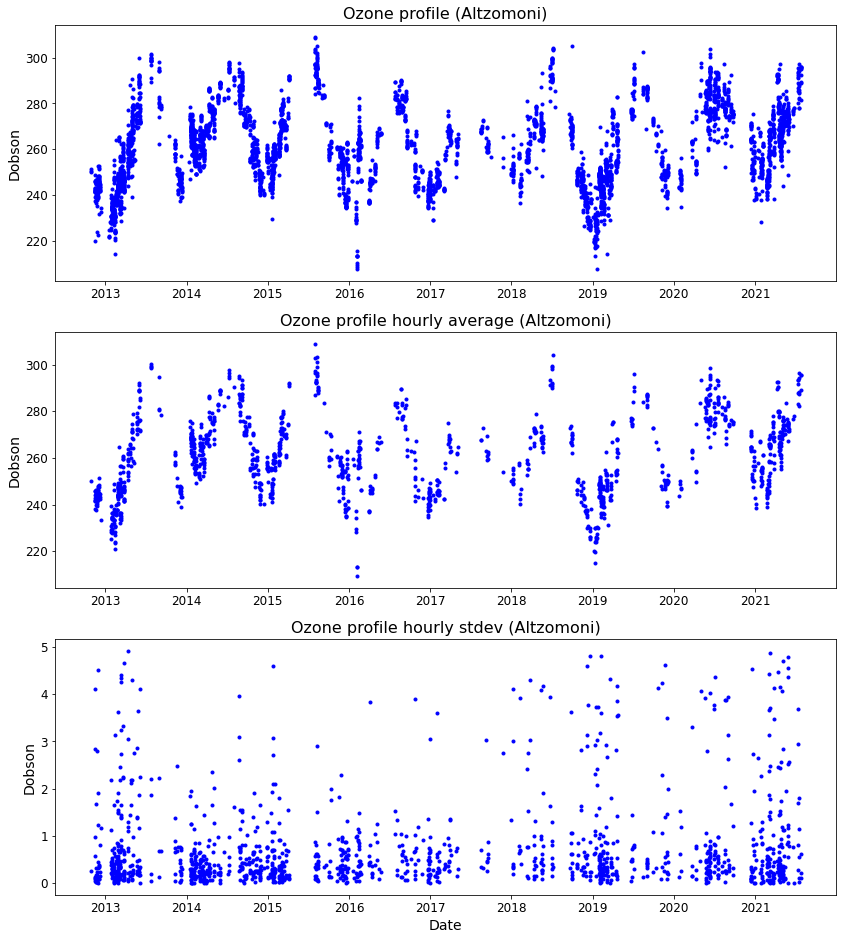

In [11]:
## pyplot plotting MULTI
# PANDONIA = loc, MERRA2 = merra, FTIR = ftir
# varname format = ts + source + mean/std + hourly(none)/monthly(mt) + total(none)/trop/strat 
# e.g. tsmerrameanmttrop

# Variable definition
x1 = smallts.index
y1 = smallts*1e18*10000/2.6867e20

x2 = smallts.resample('H').mean().index 
y2 = smallts.resample('H').mean()*1e18*10000/2.6867e20

x3 = smallts.resample('H').std().index 
y3 = smallts.resample('H').std()*1e18*10000/2.6867e20

plt.figure(figsize=(14,16)) 

ax0 = plt.subplot(3, 1, 1) 
## line and stdev
ax0.plot(x1, y1, '.b')
#ax0.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
## LABEL, marker and errorbar
#ax0.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
## Formatting 
#ax1.set_xticks(np.arange(0,24))
#ax0.set_xlabel('Date',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Dobson',size=14)
ax0.set_title("Ozone profile (Altzomoni)",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)

ax1 = plt.subplot(3, 1, 2) 
## line and stdev
ax1.plot(x2[y3['o3column']<5], y2[y3['o3column']<5], '.b')
#ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
## LABEL, marker and errorbar
#ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
## Formatting 
#ax1.set_xticks(np.arange(0,24))
#ax1.set_xlabel('Date',size=14)
ax1.set_ylabel('Dobson',size=14)
ax1.set_title("Ozone profile hourly average (Altzomoni)",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

ax2 = plt.subplot(3, 1, 3) 
## line and stdev
ax2.plot(x3[y3['o3column']<5], y3[y3['o3column']<5], '.b')
#ax1.fill_between(x1, y1-err1, y1+err1,alpha=.25, edgecolor='#3F7F4C', facecolor='b',linewidth=0)
## LABEL, marker and errorbar
#ax1.errorbar(x1, y1, yerr=err1, fmt='bo', label='')
## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax2.set_xlabel('Date',size=14)
ax2.set_ylabel('Dobson',size=14)
ax2.set_title("Ozone profile hourly stdev (Altzomoni)",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax2.tick_params(labelsize=12)



In [12]:
#identificacion de outliers en periodos de tiempo, eventos extremos, tratar de relacionarlos con temperatura y presion


In [24]:
#simple masking same year
#mask=(smallts.index.month>4)&(smallts.index.month<9)
mask=smallts.index.month<3
#print(mask)
tempdict = {'time': smallts.index[mask], 'o3column': smallts['o3column'][mask]}
filtereddf = pd.DataFrame(data=tempdict)
filteredts = filtereddf.set_index('time')
filteredts
filteredtsmean_yr = filteredts.o3column.groupby(filteredts.index.year).mean()
filteredtsstd_yr = filteredts.o3column.groupby(filteredts.index.year).std()

In [39]:
#not simple masking multiyear
frommonth = 10
tomonth = 2
years=np.arange(smallts.index[0].year,smallts.index[-1].year+1)
for ele in years:
    tempmean=smallts["%i-%02i-01" % (ele-1,frommonth):"%i-%02i-01" % (ele,tomonth+1)].o3column.mean()
    tempstd=smallts["%i-%02i-01" % (ele-1,frommonth):"%i-%02i-01" % (ele,tomonth+1)].o3column.std()
    try:
        #thingtotry
        
    except:
        pass

[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]


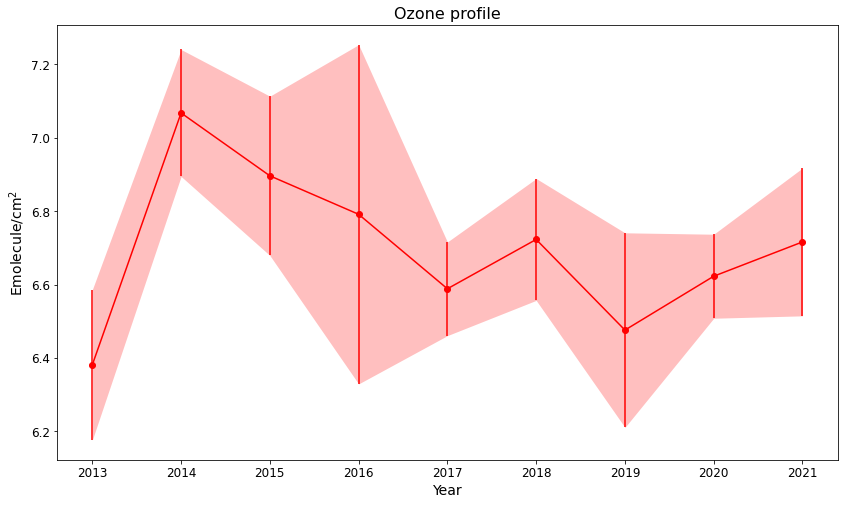

In [26]:
## pyplot plotting SINGLE

# Variable definition
xf = filteredtsmean_yr.index 
yf = filteredtsmean_yr
errf = filteredtsstd_yr

### INITIALIZATION
fig, ax1 = plt.subplots(figsize=(14, 8))

## line and stdev
ax1.plot(xf, yf, '-r')
ax1.fill_between(xf, yf-errf, yf+errf,alpha=.25, edgecolor='#3F7F4C', facecolor='r',linewidth=0)

## LABEL, marker and errorbar
ax1.errorbar(xf, yf, yerr=errf, fmt='ro', label='')

## Formatting 
#ax1.set_xticks(np.arange(0,24))
ax1.set_xlabel('Year',size=14)
ax1.set_ylabel('Emolecule/cm$^2$',size=14)
ax1.set_title("Ozone profile",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

## SAVEFIG
#plt.savefig('D:\\CCA\\PANDONIA\\diurnalO3PanAltzMERRA.png')

In [12]:
ds.close()

In [10]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF4):
    PI_NAME: Grutter;Michel
    PI_AFFILIATION: Universidad Nacional Autonoma de Mexico;UNAM
    PI_ADDRESS: Centro de Ciencias de la Atmosfera UNAM;04510 Mexico City;MEXICO
    PI_EMAIL: grutter@unam.mx
    DO_NAME: Stremme;Wolfgang
    DO_AFFILIATION: Universidad Nacional Autonoma de Mexico;UNAM
    DO_ADDRESS: Centro de Ciencias de la Atmosfera UNAM;04510 Mexico City;MEXICO
    DO_EMAIL: stremme@atmosfera.unam.mx
    DS_NAME: Bezanilla;Alejandro
    DS_AFFILIATION: Universidad Nacional Autonoma de Mexico;UNAM
    DS_ADDRESS: Centro de Ciencias de la Atmosfera UNAM;04510 Mexico City;MEXICO
    DS_EMAIL: abezanilla@atmosfera.unam.mx
    DATA_DESCRIPTION: FTIR vmr vertical profile data of O3 at Altzomoni (Mexico)
    DATA_DISCIPLINE: ATMOSPHERIC.CHEMISTRY;REMOTE.SENSING;GROUNDBASED
    DATA_GROUP: EXPERIMENTAL;PROFILE.STATIONARY
    DATA_LOCATION: ALTZOMONI
    DATA_SOURCE: FTIR.O3_UNAM001
    DATA_VA

In [59]:
i=2014
j=4
dote = "%i-%02i-01" % (i,j)
print(dote)
smallts["%i-%02i-01" % (i,j):"%i-%02i-01" % (i+2,j+2)].o3column.mean()

2014-04-01


7.097343

In [57]:
smallts.o3column.mean()

7.000569